## Setup

In [4]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Conv1D, Conv2D, Layer, \
LSTM, GlobalAveragePooling1D, subtract, add, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [5]:
# metrics
import keras.backend as K

def max_absolute_error(y_true, y_pred):
    return K.max(K.abs(y_pred - y_true), axis=0)[-1]

def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=0)[-1]

In [6]:
# utils
def sequentialize(arr, seq_lenght, look_ahead):
    early_stopping = arr.shape[0] - seq_lenght - look_ahead + 1
    x_dataset = np.zeros((early_stopping, seq_lenght, arr.shape[1]))
    y_dataset = np.zeros((early_stopping,look_ahead))
    for i in range(early_stopping):
        x_dataset[i] = arr[i:i + seq_lenght]
        y_dataset[i] = arr[i + seq_lenght:i+seq_lenght+look_ahead, 0]
    return x_dataset, y_dataset

def split_dataset(arr,ratio):
    dataset_limit = int(arr.shape[0]*ratio)
    train = arr[:dataset_limit]
    val = arr[dataset_limit:]
    return train, val

def data_scale(arr):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(arr.reshape(-1,1))
    new_arr = arr / (scaler.data_max_ - scaler.data_min_)
    return new_arr, scaler

In [7]:
# general hyperparameters
training_data_ratio = 0.9
sample_length = 128
step_ahead = 32
batch_size = 32
dropout_ratio = 0.2
epoch = 5

basin = "reno"
river_station = "casalecchio-chiusa"
rain_station = "vergato"
start_year = 2006
end_year = 2019

In [8]:
def doubleDense(units,x):
    x = Dense(units)(x)
    x = Dense(units)(x)
    return x

## Load Input

In [9]:
def load_input(sample_lenght, training_data_ratio, look_ahead):
    dataset_level = pd.read_csv("data/level/{}/{}/{}-{}.csv".format(basin, river_station, start_year, end_year),
                                parse_dates=[0], index_col=0)
    dataset_rain = pd.read_csv("data/rain/{}/{}/{}-{}.csv".format(basin, rain_station, start_year, end_year),
                               parse_dates=[0], index_col=0)

    # (to save space in file) create new column as index
    dataset_level['rain'] = dataset_rain.values

    #rolling averange on rain and level to remove noise
    dataset_level = dataset_level.rolling(24).mean().fillna(method='bfill')

    dataset_level = dataset_level.dropna()

    dataset_level['level'], _ = data_scale(dataset_level['level'].values)
    dataset_level['rain'], _ = data_scale(dataset_level['rain'].values)
    dataset_level['dayofyear'], _ = data_scale(dataset_level.index.dayofyear.values)

    dates = dataset_level.index.values

    dataset = dataset_level.values

    x_dataset, y_dataset = sequentialize(dataset, sample_lenght, look_ahead)

    train_x, val_x = split_dataset(x_dataset, training_data_ratio)
    train_y, val_y = split_dataset(y_dataset, training_data_ratio)


    val_dates = dates[-val_y.shape[0]:]

    return train_x, train_y, val_x, val_y, val_dates


train_x, train_y, val_x, val_y, val_dates = \
    load_input(sample_length, training_data_ratio, step_ahead)

## LSTM

In [10]:
### LSTM Hyperparameters
memory = 8

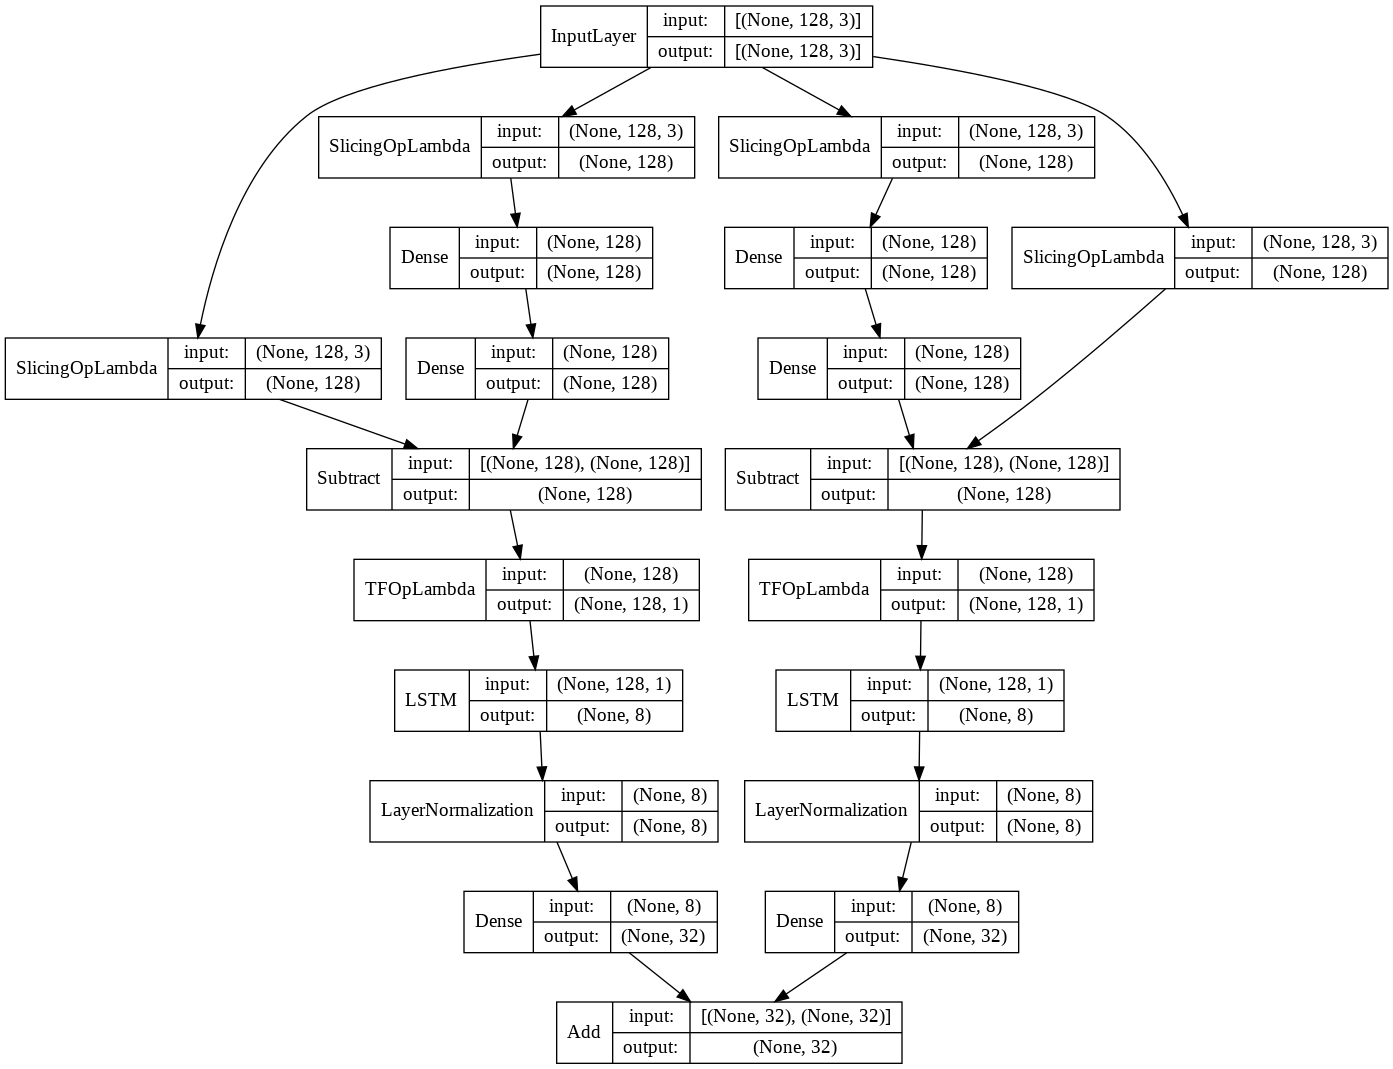

In [11]:
def LSTM_layer_wrapper(units,x):
    x = tf.expand_dims(x,axis=-1)
    x = LSTM(units=memory)(x)
    x = LayerNormalization()(x)
    x = Dense(units)(x)
    return x

in_seq = Input(shape=(sample_length, 3))
timeof = doubleDense(sample_length,in_seq[:,:,2])
timeof2 = doubleDense(sample_length,in_seq[:,:,2])
river = LSTM_layer_wrapper(step_ahead,subtract([in_seq[:,:,0],timeof]))
rain = LSTM_layer_wrapper(step_ahead,subtract([in_seq[:,:,1],timeof2]))
out = add([river,rain])
lstm_model = Model(inputs=[in_seq], outputs=out)
lstm_model.compile(loss='mse', optimizer='adam', metrics=[max_absolute_error, mean_absolute_error])
lstm_model.build(input_shape=(train_x.shape))
plot_model(lstm_model,show_layer_names=False, show_shapes=True)

In [ ]:
lstm_model.summary()

In [12]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=2, restore_best_weights=True)
history = lstm_model.fit(train_x, train_y,
                            validation_data=(val_x,val_y),
                            epochs=epoch, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/5
6899/6899 [==============================] - 431s 62ms/step - loss: 0.0097 - max_absolute_error: 0.2409 - mean_absolute_error: 0.0527 - val_loss: 0.0018 - val_max_absolute_error: 0.0668 - val_mean_absolute_error: 0.0407
Epoch 2/5
6899/6899 [==============================] - 427s 62ms/step - loss: 0.0015 - max_absolute_error: 0.1862 - mean_absolute_error: 0.0352 - val_loss: 0.0015 - val_max_absolute_error: 0.0701 - val_mean_absolute_error: 0.0436
Epoch 3/5
6899/6899 [==============================] - 423s 61ms/step - loss: 0.0013 - max_absolute_error: 0.1798 - mean_absolute_error: 0.0337 - val_loss: 0.0014 - val_max_absolute_error: 0.0722 - val_mean_absolute_error: 0.0452
Epoch 4/5
6899/6899 [==============================] - 423s 61ms/step - loss: 0.0012 - max_absolute_error: 0.1779 - mean_absolute_error: 0.0332 - val_loss: 0.0026 - val_max_absolute_error: 0.0680 - val_mean_absolute_error: 0.0405
Epoch 5/5
6899/6899 [==============================] - 417s 60ms/step - loss: 0.

## Feed-Forward

In [13]:
inner_dimension = 8

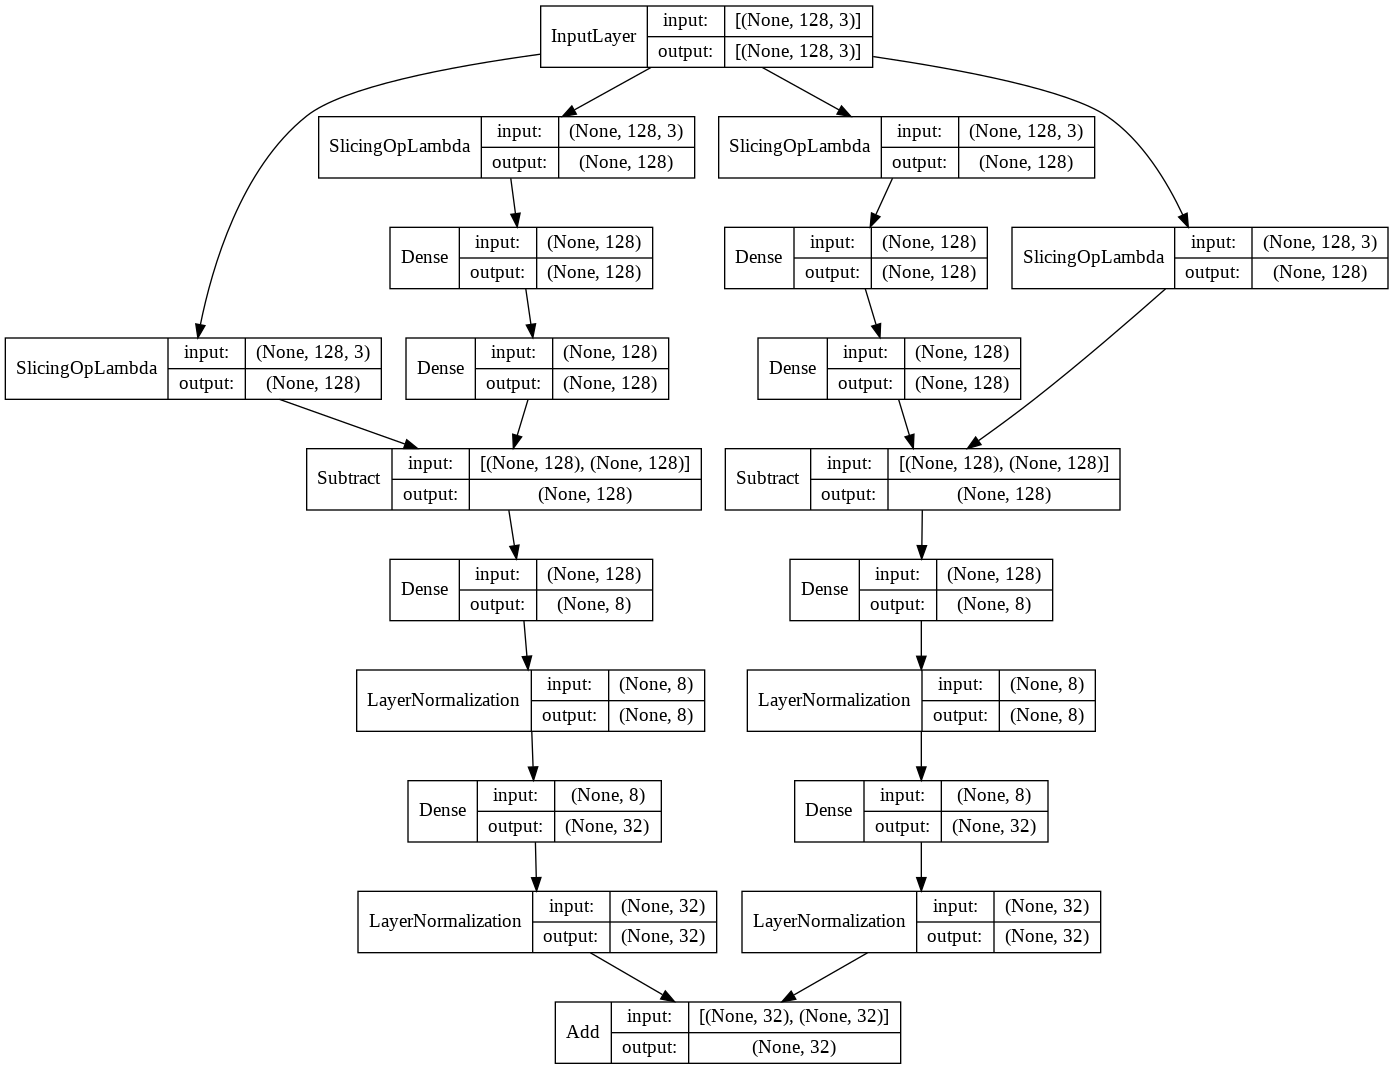

In [14]:
def encoding(units,x):
    x = Dense(inner_dimension)(x)
    x = LayerNormalization()(x)
    x = Dense(units)(x)
    x = LayerNormalization()(x)
    return x

in_seq = Input(shape=(sample_length, 3))
timeof = doubleDense(sample_length,in_seq[:,:,2])
timeof2 = doubleDense(sample_length,in_seq[:,:,2])
river = encoding(step_ahead,subtract([in_seq[:,:,0],timeof]))
rain = encoding(step_ahead,subtract([in_seq[:,:,1],timeof2]))
out = add([rain,river])
ff_model = Model(inputs=in_seq, outputs=out)
ff_model.compile(loss='mse', optimizer='adam', metrics=[max_absolute_error, mean_absolute_error])
ff_model.build(input_shape=(train_x.shape))
plot_model(ff_model, show_layer_names=False, show_shapes=True)

In [15]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0.00001, patience=3, restore_best_weights=True)
history = ff_model.fit(train_x, train_y,
                            validation_data=(val_x,val_y),
                            epochs=epoch, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/5
6899/6899 [==============================] - 19s 3ms/step - loss: 0.0394 - max_absolute_error: 0.3865 - mean_absolute_error: 0.1530 - val_loss: 0.0133 - val_max_absolute_error: 0.0999 - val_mean_absolute_error: 0.0779
Epoch 2/5
6899/6899 [==============================] - 17s 3ms/step - loss: 0.0043 - max_absolute_error: 0.1992 - mean_absolute_error: 0.0437 - val_loss: 0.0023 - val_max_absolute_error: 0.0668 - val_mean_absolute_error: 0.0411
Epoch 3/5
6899/6899 [==============================] - 17s 3ms/step - loss: 0.0024 - max_absolute_error: 0.1946 - mean_absolute_error: 0.0378 - val_loss: 0.0020 - val_max_absolute_error: 0.0653 - val_mean_absolute_error: 0.0386
Epoch 4/5
6899/6899 [==============================] - 18s 3ms/step - loss: 0.0015 - max_absolute_error: 0.1877 - mean_absolute_error: 0.0348 - val_loss: 0.0019 - val_max_absolute_error: 0.0708 - val_mean_absolute_error: 0.0454
Epoch 5/5
6899/6899 [==============================] - 17s 3ms/step - loss: 0.0014 - max

## TCN

In [17]:
!pip install keras-tcn --no-dependencies

In [18]:
from tcn import TCN

In [19]:
inner_encoding = 8

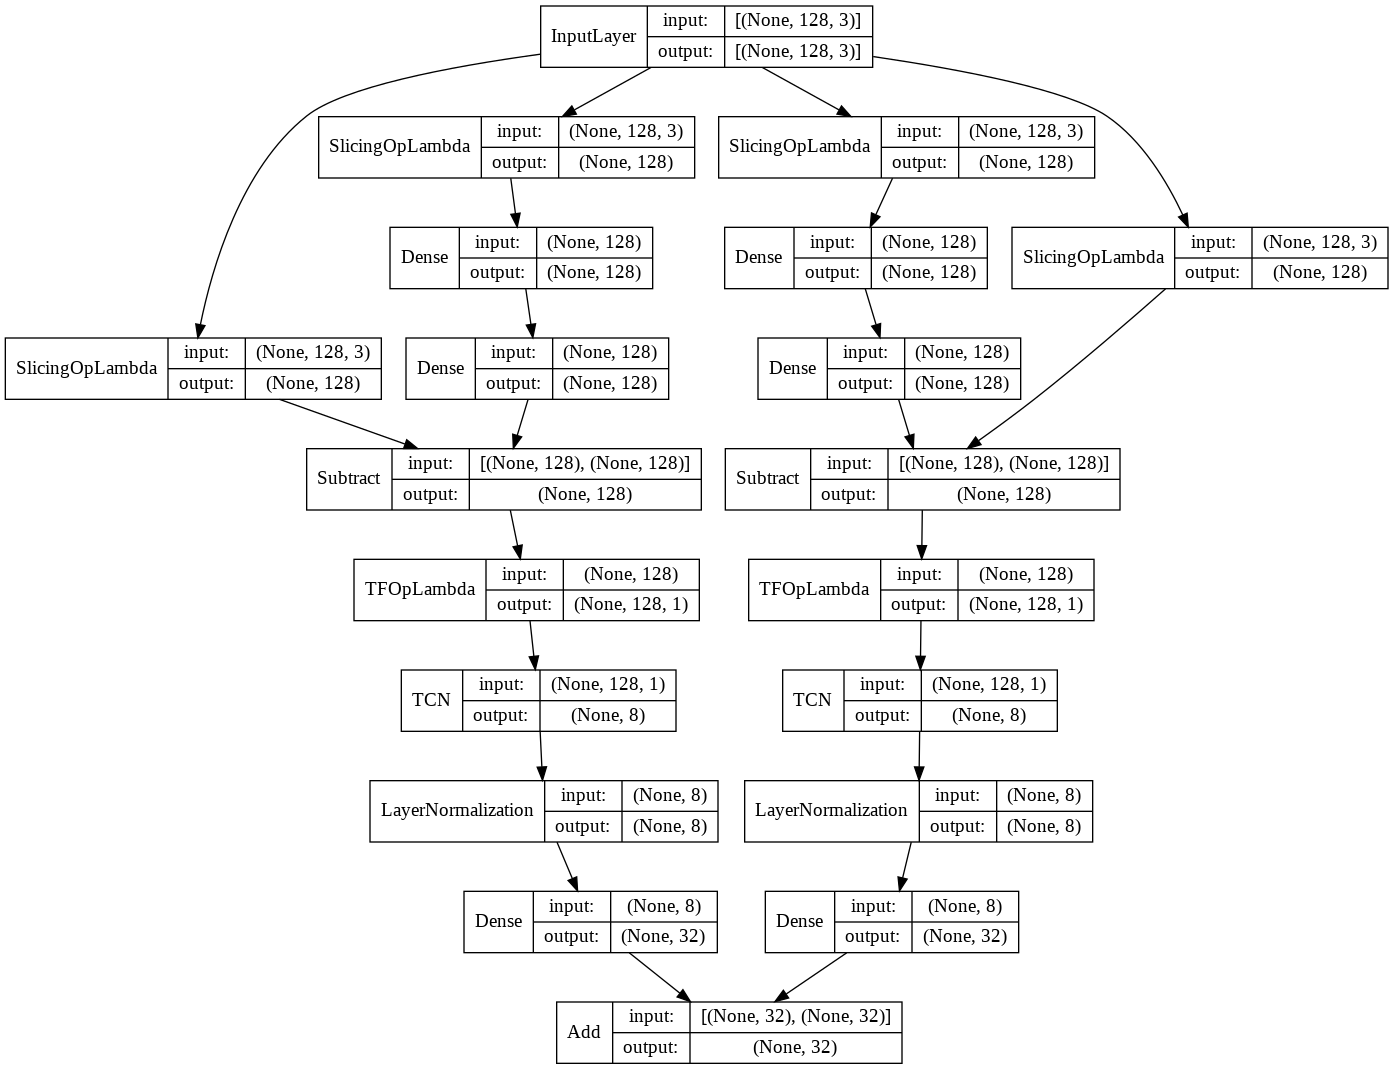

In [20]:
def TCN_layer(units,x):
    x = tf.expand_dims(x,axis=-1)
    x = TCN(inner_encoding, kernel_size =2, dilations=[1,2,4], use_skip_connections=True)(x)
    x = LayerNormalization()(x)
    x = Dense(units)(x)
    return x

in_seq = Input(shape=(sample_length, 3))
timeof = doubleDense(sample_length,in_seq[:,:,2])
timeof2 = doubleDense(sample_length,in_seq[:,:,2])
river = TCN_layer(step_ahead,subtract([in_seq[:,:,0],timeof]))
rain = TCN_layer(step_ahead,subtract([in_seq[:,:,1],timeof2]))
out = add([rain,river])
tcn_model = Model(inputs=in_seq, outputs=out)
tcn_model.compile(loss='mse', optimizer='adam', metrics=[max_absolute_error, mean_absolute_error])
tcn_model.build(input_shape=(train_x.shape))
plot_model(tcn_model, show_layer_names=False, show_shapes=True)

In [21]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0.00001, patience=3, restore_best_weights=True)
history = tcn_model.fit(train_x, train_y,
                            validation_data=(val_x,val_y),
                            epochs=epoch, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/5
6899/6899 [==============================] - 243s 35ms/step - loss: 0.0235 - max_absolute_error: 0.2459 - mean_absolute_error: 0.0621 - val_loss: 0.0023 - val_max_absolute_error: 0.0695 - val_mean_absolute_error: 0.0429
Epoch 2/5
6899/6899 [==============================] - 240s 35ms/step - loss: 0.0018 - max_absolute_error: 0.1935 - mean_absolute_error: 0.0359 - val_loss: 0.0028 - val_max_absolute_error: 0.0688 - val_mean_absolute_error: 0.0423
Epoch 3/5
6899/6899 [==============================] - 243s 35ms/step - loss: 0.0018 - max_absolute_error: 0.1943 - mean_absolute_error: 0.0361 - val_loss: 0.0026 - val_max_absolute_error: 0.0743 - val_mean_absolute_error: 0.0474
Epoch 4/5
6899/6899 [==============================] - 240s 35ms/step - loss: 0.0017 - max_absolute_error: 0.1929 - mean_absolute_error: 0.0355 - val_loss: 0.0016 - val_max_absolute_error: 0.0644 - val_mean_absolute_error: 0.0382
Epoch 5/5
6899/6899 [==============================] - 242s 35ms/step - loss: 0.

## Transformer

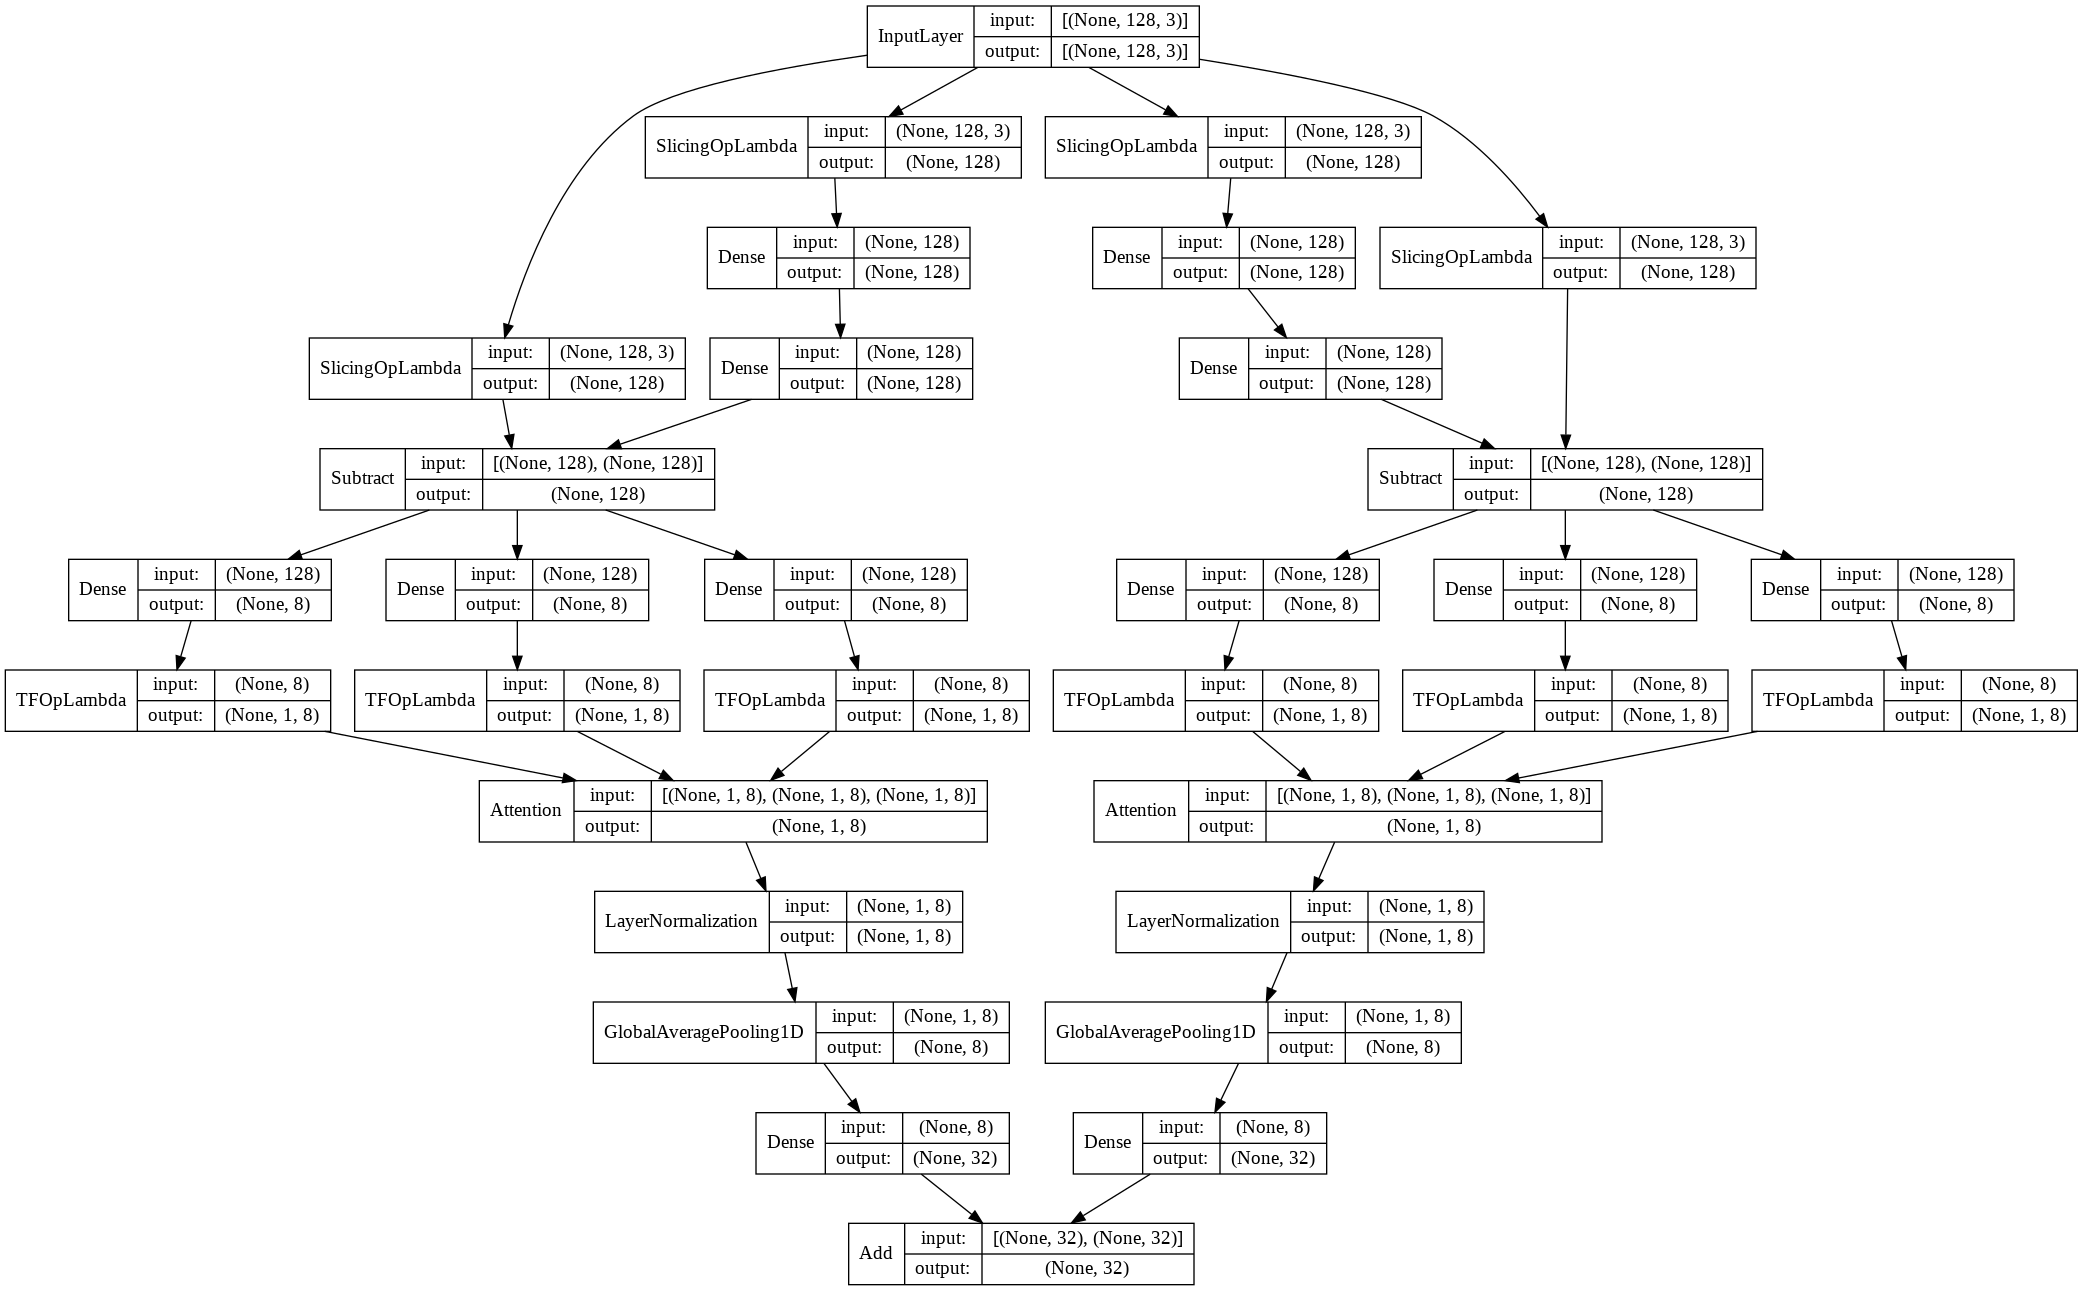

In [22]:
def transformerRegression(units,x):
    query = Dense(8)(x)
    value = Dense(8)(x)
    key = Dense(8)(x)
    query, value, key = [tf.expand_dims(x,axis=1) for x in [query,value,key]]
    x = Attention()([query,value,key])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D(data_format='channels_last')(x)
    x = Dense(units)(x)
    return x

in_seq = Input(shape=(sample_length, 3))
timeof = doubleDense(sample_length,in_seq[:,:,2])
timeof2 = doubleDense(sample_length,in_seq[:,:,2])
river = transformerRegression(step_ahead,subtract([in_seq[:,:,0],timeof]))
rain = transformerRegression(step_ahead,subtract([in_seq[:,:,1],timeof2]))
out = add([rain,river])
transformer_model = Model(inputs=in_seq, outputs=out)
transformer_model.compile(loss='mse', optimizer='adam', metrics=[max_absolute_error, mean_absolute_error])
transformer_model.build(input_shape=(train_x.shape))
plot_model(transformer_model, show_layer_names=False, show_shapes=True)

In [23]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0.00001, patience=3, restore_best_weights=True)
history = transformer_model.fit(train_x, train_y,
                            validation_data=(val_x,val_y),
                            epochs=epoch, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/5
6899/6899 [==============================] - 22s 3ms/step - loss: 0.0119 - max_absolute_error: 0.2396 - mean_absolute_error: 0.0632 - val_loss: 0.0019 - val_max_absolute_error: 0.0850 - val_mean_absolute_error: 0.0570
Epoch 2/5
6899/6899 [==============================] - 21s 3ms/step - loss: 0.0016 - max_absolute_error: 0.1871 - mean_absolute_error: 0.0356 - val_loss: 0.0019 - val_max_absolute_error: 0.0632 - val_mean_absolute_error: 0.0357
Epoch 3/5
6899/6899 [==============================] - 20s 3ms/step - loss: 0.0014 - max_absolute_error: 0.1868 - mean_absolute_error: 0.0346 - val_loss: 0.0014 - val_max_absolute_error: 0.0604 - val_mean_absolute_error: 0.0347
Epoch 4/5
6899/6899 [==============================] - 20s 3ms/step - loss: 0.0017 - max_absolute_error: 0.1871 - mean_absolute_error: 0.0356 - val_loss: 0.0017 - val_max_absolute_error: 0.0651 - val_mean_absolute_error: 0.0383
Epoch 5/5
6899/6899 [==============================] - 21s 3ms/step - loss: 0.0013 - max

In [24]:
predict_level_trasformer = transformer_model.predict(val_x)
predict_level_tcn = tcn_model.predict(val_x)
predict_level_ff = ff_model.predict(val_x)
predict_level_lstm = lstm_model.predict(val_x)

In [25]:
max_error_tr = np.max(np.abs(predict_level_trasformer-val_y),axis=0)
max_error_tcn = np.max(np.abs(predict_level_tcn-val_y),axis=0)
max_error_ff = np.max(np.abs(predict_level_ff-val_y),axis=0)
max_error_lstm = np.max(np.abs(predict_level_lstm-val_y),axis=0)
print("max error trasformer {}".format(max_error_tr[-1]))
print("max error tcn {}".format(max_error_tcn[-1]))
print("max error ff {}".format(max_error_ff[-1]))
print("max error lstm {}".format(max_error_lstm[-1]))

max error trasformer 0.4197681738189334
max error tcn 0.4272903953593141
max error ff 0.39568596072722895
max error lstm 0.4007930538039937


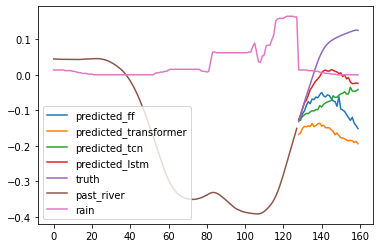

In [26]:
obs = 21765
plt.plot(list(range(sample_length,sample_length+step_ahead)),predict_level_ff[obs],label='predicted_ff')
plt.plot(list(range(sample_length,sample_length+step_ahead)),predict_level_trasformer[obs],label='predicted_transformer')
plt.plot(list(range(sample_length,sample_length+step_ahead)),predict_level_tcn[obs],label='predicted_tcn')
plt.plot(list(range(sample_length,sample_length+step_ahead)),predict_level_lstm[obs],label='predicted_lstm')
plt.plot(list(range(sample_length,sample_length+step_ahead)),val_y[obs],label='truth')
plt.plot(list(range(sample_length)),val_x[obs,:,0],label='past_river')
plt.plot(list(range(sample_length+step_ahead)),np.concatenate((val_x[obs,:,1],val_x[obs+1,:step_ahead,1])),label='rain')
plt.legend()
plt.show(block=False)